In [1]:
#Dependencias
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Carga y preparacion de dataset de dataset
df = pd.read_csv("http://www2.udec.cl/~jorgecastillo/AirPassengers.txt")

df.columns = [
    'month',
    'passengers'
]

df.index = pd.Index(sm.tsa.datetools.dates_from_range('1949m1', '1960m12'))
#df

<AxesSubplot:>

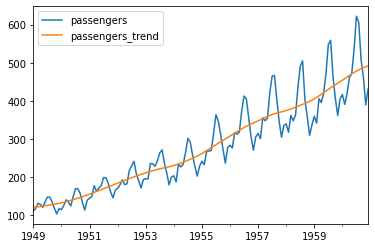

In [3]:
#1.A -  Para el caso del calculo de tendencia de la serie de tiempo, se grafica los datos a partir de la aplicacion del filtro Hodrick-Prescott,
#       dando como resultado, que esta tendencia es CRECIENTE y MULTIPLICATIVA en el periodo de estudio

hp = sm.tsa.filters.hpfilter(df['passengers'])

df['passengers_cycle'] = hp[0]
df['passengers_trend'] = hp[1]

df[['passengers','passengers_trend']].plot()

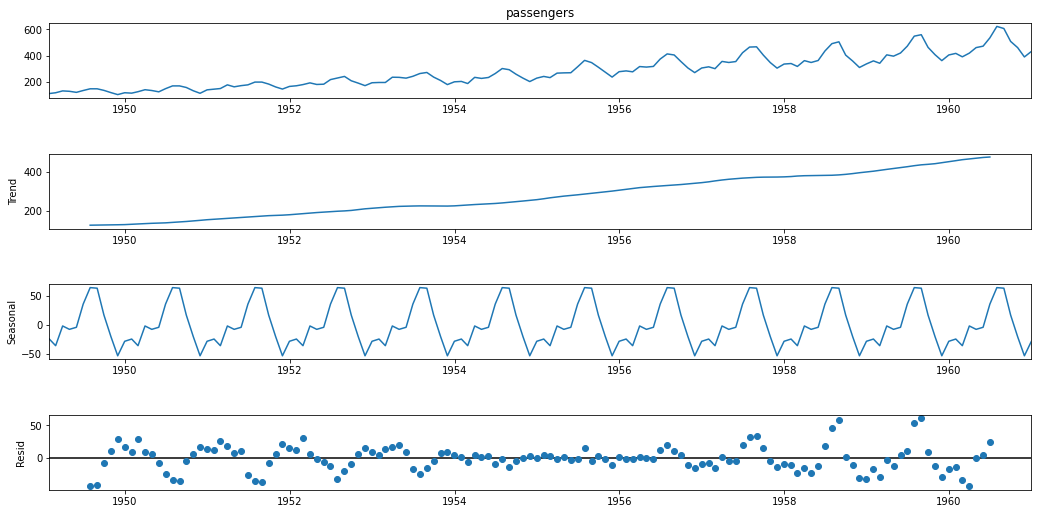

In [4]:
decomposition = seasonal_decompose(df['passengers'].interpolate("linear"))

fig = decomposition.plot()
fig.set_size_inches(16, 8)

In [5]:
#1.B -  Para el caso de calculo de estacionalidad de la serie de tiempo, se grafican los datos con el metodo seasonal_decompose() con la variable de pasajeros como argumento,
#       dando esto un componente estacional marcado para los años de estudio

In [6]:
#1.C -
# - Irregularidades y Shocks Aleatorios: Dentro del caso de estudio, se puede apreciar de que no hay homocedasticidad en todo el residuo, 
#   solo podia haber desde el año 1954 hasta aproximadamente el primer semestre el año 1957, de ahi en adelante, se precentan hechos como en el segundo semestre de 1958 y Q3 1959
# - Estacionariedad: se puede apreciar mediante la prueba de Dickey-Fuller, que la serie de tiempo no es estacionaria

adfuller(df['passengers'])[1]

0.9918802434376413

In [7]:
#1.D - 

0.054213290283826786

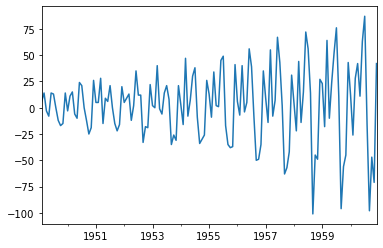

In [8]:
#1ra diferenciacion
df['passengers'].diff().dropna().plot()
adfuller(df['passengers'].diff().dropna())[1]

2.732891850014397e-29

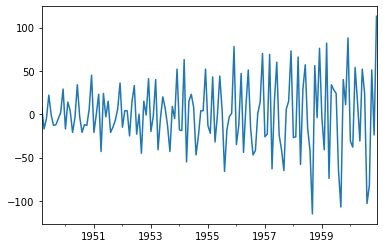

In [9]:
#2da diferenciacion
df['passengers'].diff().diff().dropna().plot()
adfuller(df['passengers'].diff().diff().dropna())[1]

In [10]:
#el valor de d = 2

In [11]:
#1ra diferenciacion con estacionalidad
df['passengers_stacionary_12'] = df['passengers'] - df['passengers'].shift(12)
adfuller(df['passengers_stacionary_12'].dropna())[1]

0.011551493085514982

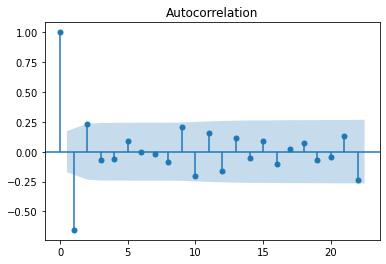

In [12]:
#1.D.A Media movil

from statsmodels.graphics.tsaplots import plot_acf
p_acf = plot_acf(df['passengers_stacionary_12'].diff().diff().dropna())

# La autocorrelacion en el caso de la diferencia entre 12 meses tiene como resultado un componente de MA (2 o 1)

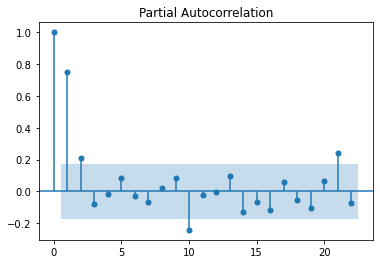

In [13]:
#1.D.B Autoregresion

from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf = plot_pacf(df['passengers_stacionary_12'].dropna())

# La autocorrelacion parcial en el caso de la diferencia entre 12 meses tiene como resultado dos correlaciones significativas significando un componente AR (2)

In [14]:
#2 estimacion de modelo
def sarima(serie, p,d,q, P,D,Q,S):
    m = sm.tsa.statespace.SARIMAX(
        serie, 
        order = (p , d, q), 
        seasonal_order = (P, D, Q, S)
    )
    return m.fit(disp = 0)

1022.9784165191226

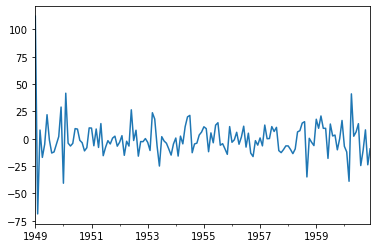

In [15]:
modelo = sarima(df['passengers'], 2,2,1, 0,1,0,12)
modelo.resid.plot()
modelo.aic

1020.4485879293138

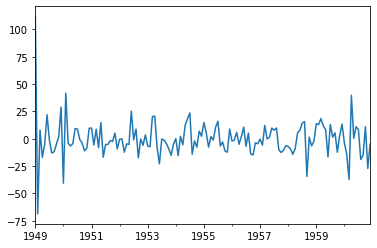

In [16]:
modelo = sarima(df['passengers'], 2,2,2, 0,1,0,12)
modelo.resid.plot()
modelo.aic

In [17]:
#El mejor modelo se ajusta en la estimacion
# - p: 2
# - d: 2
# - q: 2
# - P: 0
# - D: 1
# - Q: 0 
# - S: 12

# - AIC: 1020.44

<AxesSubplot:>

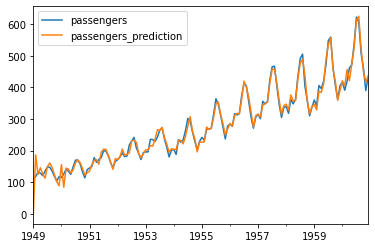

In [18]:
df['passengers_prediction'] = modelo.predict()
df[['passengers', 'passengers_prediction']].plot()

In [19]:
#3 estimacion futura modelo (12 meses posteriores al final)
def addNewFutureDatesRow(df, periods):
    s = []
    for x in range(1, (periods + 1)):
        s.append(df.index[-1] + DateOffset(months = x))
        
    return pd.DataFrame(index=s, columns = df.columns)

In [20]:
addNewFutureDatesRowDf = addNewFutureDatesRow(df, 12)
dfWithFuture = pd.concat([df, addNewFutureDatesRowDf])

In [21]:
dfWithFuture['passengers_prediction_12m_f'] = modelo.predict(
    start = 144, 
    end = 156
)

<AxesSubplot:>

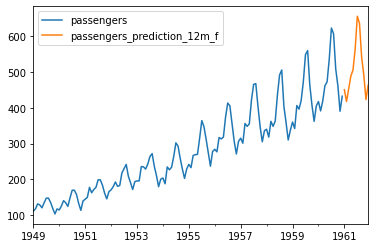

In [22]:
dfWithFuture[['passengers', 'passengers_prediction_12m_f']].plot()

In [23]:
#4
np.sqrt(mean_squared_error(dfWithFuture['passengers'][132:144], dfWithFuture['passengers_prediction'][132:144]))

#20.5089 para modelo p:2, d:2, q:1, P:0, D:1, Q:0, S: 12
#20.0614 para modelo p:2, d:2, q:2, P:0, D:1, Q:0, S:12

20.061461198504126